# Make a Video of Defect Movement
Make a video where we color each defect based on its void

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colormaps
from rtdefects.io import load_file
from rtdefects.analysis import analyze_defects
from skimage.transform import resize, warp, EuclideanTransform
from skimage import measure
from functools import lru_cache
from imageio import v3 as iio
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil

Configuration

In [2]:
run_directory = '../../../learning-defect-pde/data/8bitTIFF-video32-625C/'

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name
defect_details = out_directory / 'defect-details.json'

## Load in the Void Data
Load in the void tracks from a previous notebook and the overall summaries in each

In [4]:
void_tracks = pd.read_json(out_directory / 'tracks.json', lines=True)
void_tracks.head(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,touches_side,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,8,9,0,"[[85.7283950617, 56.2716049383], [85.177723979...","[False, False, False, False, False, False, Fal...","[0, 0, 0, 1, 0, 0, 1, 0, 0]","[0.0, 1.1839539551, 0.5069242873, 2.0260066177...",5.14722,0.571913,"[0.0, 1.1839539551, 1.8754456524, 4.2254130879...",16.077126,1.786347,"[5.0777062519, 5.4115163798, 5.3523723485, 5.5...",5.527906,4.548642,0.014549
1,0,0,1,0,"[[239.9805825243, 1009.3398058252]]",[True],[25],None,NaN,NaN,None,NaN,NaN,[5.7258989056],5.725899,5.725899,NaN


In [5]:
frame_data = pd.read_json(out_directory / 'defect-details.json', lines=True)
frame_data.head(2)

,void_frac,void_count,type,radii,radii_average,positions,touches_side,image_path,mask_path,positions_corrected-fft,drift
0,0.276405,26,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.0777062519, 12.2832766822, 12.4121708381, 5...",8.395412,"[[85.7283950617, 56.2716049383], [305.48312236...","[False, False, False, False, False, False, Fal...",../../../learning-defect-pde/data/8bitTIFF-vid...,output/8bitTIFF-video32-625C/masks/TIFF-video3...,"[[85.7283950617, 56.2716049383], [305.48312236...","[0, 0]"
1,0.346680,19,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.4115163798, 12.3607744647, 12.2832766822, 5...",9.616485,"[[83.847826087, 58.9456521739], [304.395833333...","[False, False, False, False, False, False, Fal...",../../../learning-defect-pde/data/8bitTIFF-vid...,output/8bitTIFF-video32-625C/masks/TIFF-video3...,"[[85.1777239795, 57.319702418], [305.725731225...","[-1, 2]"


## Make colors for each void
I want a color for each frame that are all from the same pallete, and that pallete to stand out from the gray background

In [6]:
cmap = colormaps['nipy_spectral']

Get a list of incremental colors, then shuffle so they are in a random order

In [7]:
colors = np.linspace(0, 1, len(void_tracks))
np.random.shuffle(colors)
colors = cmap(colors)

## Plot a Single Frame
Give each void in the frame a different color

In [8]:
frame = frame_data.iloc[0]

In [9]:
frame

void_frac                                                           0.276405
void_count                                                                26
type                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
radii                      [5.0777062519, 12.2832766822, 12.4121708381, 5...
radii_average                                                       8.395412
positions                  [[85.7283950617, 56.2716049383], [305.48312236...
touches_side               [False, False, False, False, False, False, Fal...
image_path                 ../../../learning-defect-pde/data/8bitTIFF-vid...
mask_path                  output/8bitTIFF-video32-625C/masks/TIFF-video3...
positions_corrected-fft    [[85.7283950617, 56.2716049383], [305.48312236...
drift                                                                 [0, 0]
Name: 0, dtype: object

Load in the image and mask

In [10]:
image = load_file(frame['image_path'])

In [11]:
mask = iio.imread(frame['mask_path'])

Get the global ID for each void in this image

In [12]:
def get_global_id(frame_id: int) -> list[int]: 
    """Get the global void numbers for each void in this image
    
    Args:
        frame_id: ID for the frame in question
    Returns:
        Lookup of void number to overall number
    """
    
    # Determine how many voids I have
    void_count = frame_data.iloc[frame_id]['void_count']
    output = [0] * void_count
    
    # Get the tracks which could appear in this frame
    my_tracks = void_tracks.query(f'start_frame <= {frame_id} and end_frame >= {frame_id}')
    
    # For each void in the global, get the id for this frame
    for gid, track in my_tracks.iterrows():
        local_frame = frame_id - track['start_frame']
        local_id = track['local_id'][local_frame]
        if local_id is not None: # If a void was detected in this frame
            output[local_id] = gid
    return output

In [13]:
def load_and_label_mask(frame_id, use_global_ids: bool = True) -> np.ndarray:
    """Load a mask and assign the global id to each void
    
    Args:
        frame_id: Index of the frame
        use_global_ids: Whether to label voids based their global ID
    Returns:
        Array of label for each void and -1 for unlabelled pixels
    """
    
    # Load the mask rom disk
    frame = frame_data.iloc[frame_id]
    output = iio.imread(frame['mask_path']).astype(np.uint16)
    
    # Update the IDs to the global ID
    global_ids = get_global_id(frame_id)
    for local_id, global_id in enumerate(global_ids):
        local_frame = output[local_id, :, :]
        local_frame[local_frame > 0] = global_id + 1
    
    return output
labels = load_and_label_mask(10)

Make a function to insert missing voids

In [14]:
load_and_label_mask(0).max(axis=(1, 2))

array([ 1, 16, 21, 18, 19, 20, 26, 22, 23, 24, 25, 15, 17, 13, 12, 11, 10,
       14,  9,  8,  7,  6,  5,  4,  3,  2], dtype=uint16)

In [15]:
def load_mask_with_interpolated_voids(frame_id: int) -> np.ndarray:
    """Load the mask, assign a global ID to present voids, add interpolate the position of voids which are missing"""
    
    # Load in our labels
    labels = load_and_label_mask(frame_id)
    
    # Find the missing voids
    possible_voids = void_tracks.query(f'start_frame <= {frame_id} and end_frame >= {frame_id}').index
    observed_voids = get_global_id(frame_id)
    missing_voids = set(possible_voids).difference(observed_voids)
    
    for missing_id in missing_voids:
        # Get the last frame in which this void appeared
        void_data = void_tracks.iloc[missing_id]
        my_frame = frame_id - void_data['start_frame']
        last_frame = max(i for i, x in enumerate(void_data['local_id'][:my_frame]) if x is not None)
        
        # Find the displacement between the void in that frame and now
        disp = np.subtract(void_data['positions'][my_frame], void_data['positions'][last_frame])  # Interpolated already
        
        # Move the void from the last frame by this displacement
        last_mask = load_and_label_mask(last_frame + void_data['start_frame'])
        last_id = void_data['local_id'][last_frame]
        last_mask = last_mask[last_id - 1].astype(float)
        shifted_frame = warp(last_mask, EuclideanTransform(translation=disp).inverse)
        
        # Add it to our current frame
        new_frame = ((shifted_frame > 0) * missing_id + 1).astype(np.uint8)
        labels = np.concatenate([labels, new_frame[None, :, :]], axis=0)
    return labels
labels = load_mask_with_interpolated_voids(10)

Make a colormap for each void

In [16]:
def labels_to_colors(labels, colors) -> np.ndarray:
    """Generate an array where each pixel is colored according to its label
    
    Args:
        label: Mask where we've labeled defect by index
        colors: Colors to use for each index
    Returns:
        
    """
    # Make the output
    output = np.zeros((labels.shape[1], labels.shape[2], 4))
    
    # Set the color for each pixel
    for mask in labels: 
        color = colors[mask.max() - 1]
        for i, j in zip(*np.where(mask > 0)):
            output[i, j, :] = color
    return output
colored_mask = labels_to_colors(labels, colors)

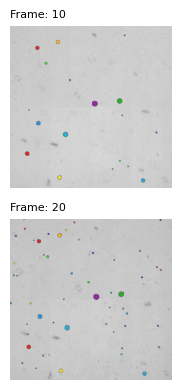

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(2, 4.))

for ax, fid in zip(axs, [10, 20]):
    # Get the images
    frame = frame_data.iloc[fid]
    image = load_file(frame['image_path'])
    labels = load_and_label_mask(fid)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot them
    ax.set_title(f'Frame: {fid}', loc='left', fontsize=8)
    im1 = ax.imshow(image, cmap='gray', alpha=0.5, extent=[0, 1, 0, 1])
    im2 = ax.imshow(colored_mask, alpha=0.8, extent=[0, 1, 0, 1])
    ax.axison = False
    
fig.tight_layout()
fig.savefig(out_directory / 'figures/frames-with-global-ids-interpolated.png', dpi=320)

## Make a Video
Go through each frame and make a video [using a function-based strategy](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation)

In [18]:
(out_directory / 'videos').mkdir(exist_ok=True)

863it [17:55,  1.42s/it]                                                                                                                                                                                                                                                                  

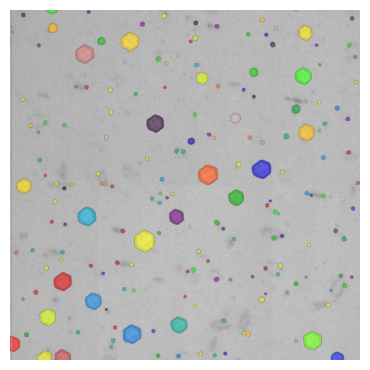

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.axison=False
frame_dir = Path(out_directory / f"videos/animation-frames/")       
if frame_dir.exists():
    shutil.rmtree(frame_dir)
frame_dir.mkdir(parents=True)

pbar = tqdm(total=len(frame_data))
im1 = ax.imshow(image, cmap='gray', alpha=0.5, extent=[0, 1, 0, 1])
im2 = ax.imshow(colored_mask, alpha=0.6, extent=[0, 1, 0, 1])

def plot_frame(i):
    pbar.update(1)
    # Get the frames
    frame = frame_data.iloc[i]
    image = load_file(frame['image_path'])
    labels = load_and_label_mask(i)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot both
    im1.set_data(image)
    colored_mask[:, 4] = 0.6
    im2.set_data(colored_mask)
    
    # Write out the current frame
    fig.savefig(frame_dir / f'frame-{i:04d}.png', dpi=320, pil_kwargs={"compression": "tiff_lzw"})
    return im1, im2
    
fig.tight_layout(pad=0)

ani = animation.FuncAnimation(fig, plot_frame, frames=len(frame_data), interval=3000 / len(frame_data), blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=16000)
ani.save(out_directory / f"videos/animation.mp4", writer=writer, dpi=320)